In [1]:
from snAPI.Main import *
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
class HH_T3:
    def __init__(self,sn,filename):
        sn.getDevice()
        sn.getFileDevice(filename)
        sn.initDevice(MeasMode.T3)
        self.t_resol=sn.deviceConfig['Resolution']/1000 #in ns
        sn.raw.measure()
        self.data = sn.raw.getData()
        self.channels=sn.raw.channel(self.data)
        self.dTimes=sn.raw.dTime_T3(self.data)[np.where(self.channels!=64)]*self.t_resol
        self.dataChannels=self.channels[np.where(self.channels!=64)]
        sn.unfold.measure()
        self.absTimes=sn.unfold.getData()[0]/1e3 # in ns
        self.df=pd.DataFrame(np.array([self.dTimes,self.absTimes,self.dataChannels]).T,columns=['dTimes','absTimes','Channels'])
        sn.closeDevice()
    def Gate(self,T):
        return self.df[(self.df['dTimes']>T)]
    def Counts(self,ch):
        return np.size(self.df['dTimes'][self.df['Channels']==ch]) 

In [3]:
def binned(times,t_res, t0, tf):
        edges=np.arange(t0,tf,t_res)
        return np.histogram(times,edges)
def edges2bins(edges):
    return edges[:-1]+np.diff(edges)/2

In [4]:
sn=snAPI()

In [11]:
dataf1='C:/Users/Mikel/Documents/Data analysis/Narrow field/Data/APD/Marker_test/default.ptu'

In [12]:
os.listdir(dataf1)

NotADirectoryError: [WinError 267] The directory name is invalid: 'C:/Users/Mikel/Documents/Data analysis/Narrow field/Data/APD/Marker_test/default.ptu'

In [13]:
m1=HH_T3(sn,filename=dataf1)

Text(0, 0.5, 'Counts')

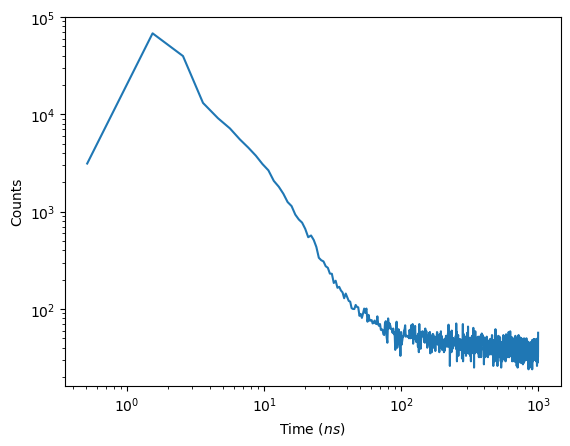

In [8]:
binning=1
counts,edges=binned(m1.df['dTimes'],m1.t_resol*binning,0,1000)
bins=edges2bins(edges)
plt.plot(bins,counts)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Time ($ns$)')
plt.ylabel('Counts')

In [30]:
from scipy.optimize import curve_fit
n0=30
def model1(x,t0,alpha,tau,B):
    return alpha*np.exp(-(x-t0)/tau)+B
def model2(x,t0,alpha1,tau1,alpha2,tau2,B):
    return alpha1*np.exp(-(x)/tau1)+alpha2*np.exp(-(x)/tau2)+B
popt, pcov = curve_fit(
    f=model2,       # model function
    xdata=bins[n0:],   # x data
    ydata=counts[n0:],   # y data
    p0=(10,100,3,10,2000,10),      # initial value of the parameters
   # uncertainties on y
)

t0=10.0
Alpha1=1499.281985091127
tau1=13.404747503060888
Alpha2=25.12083824807167
tau2=244.55130255919158
Background=37.660700230653326


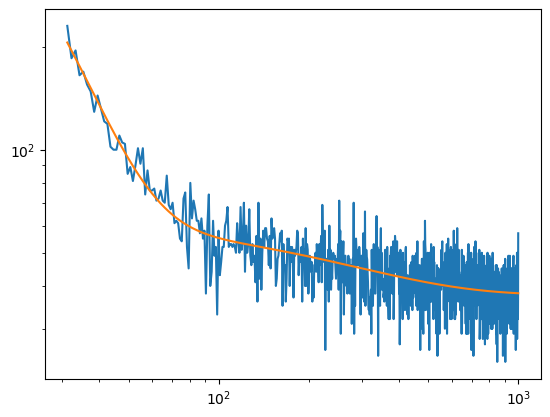

In [32]:
plt.plot(bins[n0:],counts[n0:])
plt.plot(bins[n0:],model2(bins[n0:],popt[0],popt[1],popt[2],popt[3],popt[4],popt[5]))

plt.yscale('log')
plt.xscale('log')
print('t0='+str(popt[0]))
print('Alpha1='+str(popt[1]))
print('tau1='+str(popt[2]))
print('Alpha2='+str(popt[3]))
print('tau2='+str(popt[4]))
print('Background='+str(popt[5]))

Text(0, 0.5, 'Counts')

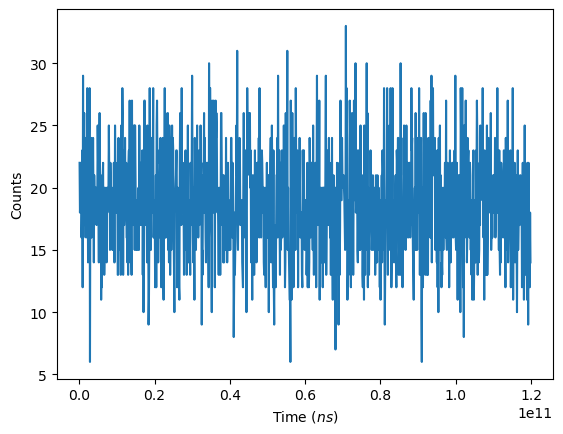

In [21]:
binning2=1e8
counts,edges=binned(m1.df['absTimes'],m1.t_resol*binning2,0,1.2e11)
bins=edges2bins(edges)
plt.plot(bins,counts)
plt.yscale('linear')
plt.xlabel('Time ($ns$)')
plt.ylabel('Counts')

Time bin is = 0.1024s


Text(0, 0.5, 'Counts')

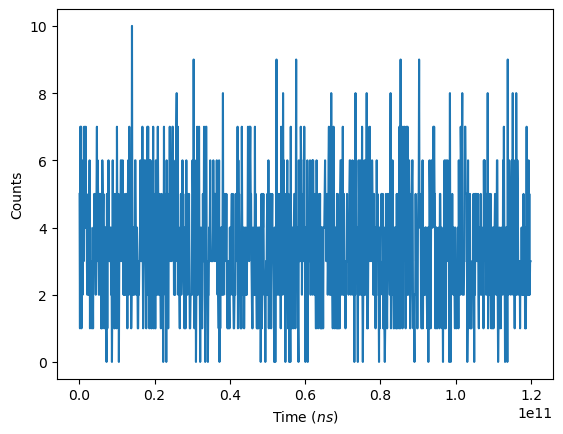

In [17]:

binning2=1e8
print('Time bin is = '+str(m1.t_resol*binning2/1e9)+'s')
df_gated=m1.Gate(50)
counts,edges=binned(df_gated['absTimes'],m1.t_resol*binning2,0,1.2e11)
bins=edges2bins(edges)
plt.plot(bins,counts)
plt.yscale('linear')
plt.xlabel('Time ($ns$)')
plt.ylabel('Counts')

Time bin is = 0.1024s


Text(0, 0.5, 'CPS (Hz)')

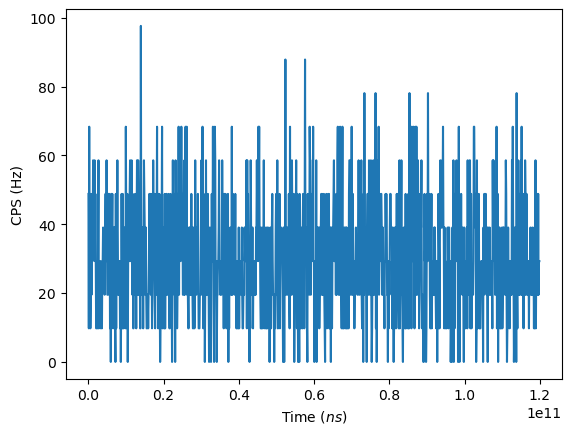

In [18]:
binning2=1e8
binTime=m1.t_resol*binning2/1e9 #in seconds
print('Time bin is = '+str(m1.t_resol*binning2/1e9)+'s')
df_gated=m1.Gate(100)
counts,edges=binned(df_gated['absTimes'],m1.t_resol*binning2,0,1.2e11)
cps=counts/binTime
bins=edges2bins(edges)
plt.plot(bins,cps)
plt.yscale('linear')
plt.xlabel('Time ($ns$)')
plt.ylabel('CPS (Hz)')

### Dead times or afterpulsing artifacts:
Dead time of the detector is 80ns --> Log(80)=1.9. There is not any photon accumulation after 80ns, so there is no problem with dead time.

Text(0.5, 0, '$Log(\\Delta T)_{Consecutive\\ photons}$')

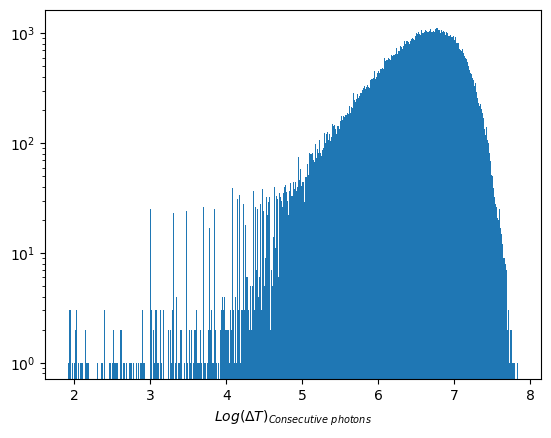

In [20]:
tdiff=np.diff(m1.df['absTimes'][m1.df['Channels']==3])
plt.hist(np.log10(tdiff),bins=1000);
plt.yscale('log')
plt.xlabel('$Log(\Delta T)_{Consecutive\ photons}$')